brought_complaints.py ran successfully
temp_all.csv exists, proceeding...


/var/folders/77/flt399_94wg6_s6ytf5x1hkm0000gn/T/ipykernel_7089/3229117369.py:36: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('temp_all.csv')


Most abundant complaint type: Illegal Parking


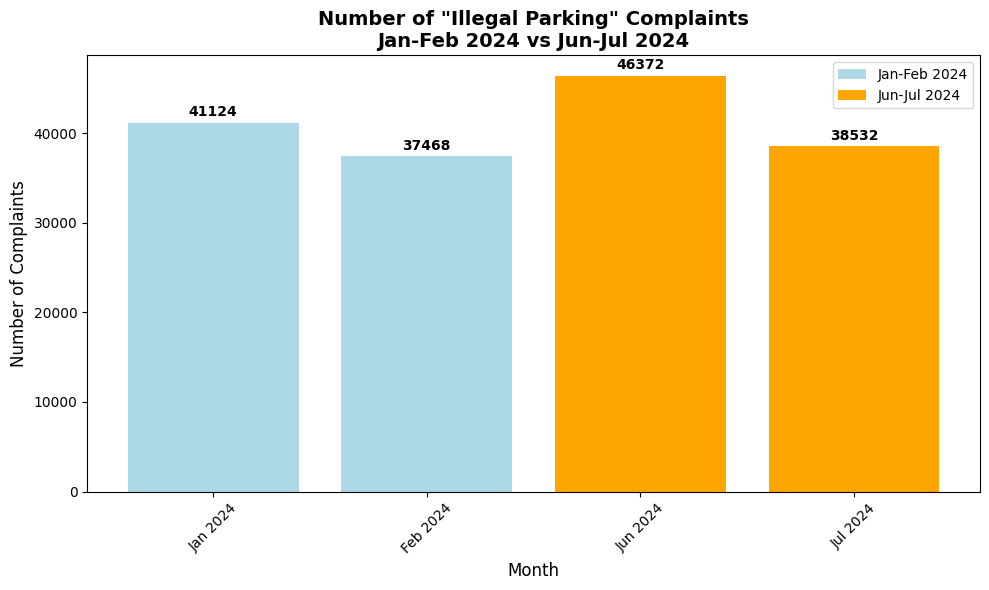


Comparison Summary for 'Illegal Parking' complaints:
Jan-Feb 2024 total: 78592
Jun-Jul 2024 total: 84904
Difference: 6312
Percentage change: 8.0%


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import json
import os

# First, let's find the most abundant complaint type overall
# Using your CLI tool to get complaint types for the entire dataset
result = subprocess.run([
    'python', 'brought_complaints.py',  # Use the correct script name
    '-i', '311_2024.csv',
    '-s', '2024-01-01',
    '-e', '2024-12-31',
    '-o', 'temp_all.csv'
], capture_output=True, text=True)

# Check if the subprocess ran successfully
if result.returncode != 0:
    print("Error running brought_complaints.py:")
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
else:
    print("brought_complaints.py ran successfully")

# Check if the file was created
if not os.path.exists('temp_all.csv'):
    print("temp_all.csv was not created!")
    print("Current directory contents:", os.listdir('.'))
    # Try running without the subprocess to see direct output
    print("\nTrying to run brought_complaints.py directly...")
    os.system('python brought_complaints.py -i 311_2024.csv -s 2024-01-01 -e 2024-12-31 -o temp_all.csv')
else:
    print("temp_all.csv exists, proceeding...")

# Load the data to find the most common complaint type
df_all = pd.read_csv('temp_all.csv')
most_common_complaint = df_all['Complaint Type'].value_counts().index[0]
print(f"Most abundant complaint type: {most_common_complaint}")

# Now get data for Jan-Feb 2024
result_jan_feb = subprocess.run([
    'python', 'brought_complaints.py', 
    '-i', '311_2024.csv',
    '-s', '2024-01-01',
    '-e', '2024-02-29',
    '-o', 'jan_feb_2024.csv'
], capture_output=True, text=True)

# Get data for June-July 2024
result_jun_jul = subprocess.run([
    'python', 'brought_complaints.py',
    '-i', '311_2024.csv',
    '-s', '2024-06-01', 
    '-e', '2024-07-31',
    '-o', 'jun_jul_2024.csv'
], capture_output=True, text=True)

# Filter the datasets to only include the most common complaint type
df_jan_feb = pd.read_csv('jan_feb_2024.csv')
df_jun_jul = pd.read_csv('jun_jul_2024.csv')

# Filter for the most common complaint type only
df_jan_feb = df_jan_feb[df_jan_feb['Complaint Type'] == most_common_complaint]
df_jun_jul = df_jun_jul[df_jun_jul['Complaint Type'] == most_common_complaint]

# Count occurrences by month
df_jan_feb['Created Date'] = pd.to_datetime(df_jan_feb['Created Date'])
df_jun_jul['Created Date'] = pd.to_datetime(df_jun_jul['Created Date'])

# Group by month for Jan-Feb
jan_feb_monthly = df_jan_feb.groupby(df_jan_feb['Created Date'].dt.to_period('M')).size()

# Group by month for Jun-Jul  
jun_jul_monthly = df_jun_jul.groupby(df_jun_jul['Created Date'].dt.to_period('M')).size()

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for plotting
months = ['Jan 2024', 'Feb 2024', 'Jun 2024', 'Jul 2024']
counts = [
    jan_feb_monthly.iloc[0] if len(jan_feb_monthly) > 0 else 0,
    jan_feb_monthly.iloc[1] if len(jan_feb_monthly) > 1 else 0,
    jun_jul_monthly.iloc[0] if len(jun_jul_monthly) > 0 else 0,
    jun_jul_monthly.iloc[1] if len(jun_jul_monthly) > 1 else 0
]

# Create bar chart with different colors for different periods
colors = ['lightblue', 'lightblue', 'orange', 'orange']
bars = ax.bar(months, counts, color=colors)

# Customize the chart
ax.set_title(f'Number of "{most_common_complaint}" Complaints\nJan-Feb 2024 vs Jun-Jul 2024', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Complaints', fontsize=12)
ax.set_xlabel('Month', fontsize=12)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
            f'{int(count)}', ha='center', va='bottom', fontweight='bold')

# Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', label='Jan-Feb 2024'),
                   Patch(facecolor='orange', label='Jun-Jul 2024')]
ax.legend(handles=legend_elements)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print comparison summary
jan_feb_total = jan_feb_monthly.sum()
jun_jul_total = jun_jul_monthly.sum()

print(f"\nComparison Summary for '{most_common_complaint}' complaints:")
print(f"Jan-Feb 2024 total: {jan_feb_total}")
print(f"Jun-Jul 2024 total: {jun_jul_total}")
print(f"Difference: {jun_jul_total - jan_feb_total}")
print(f"Percentage change: {((jun_jul_total - jan_feb_total) / jan_feb_total) * 100:.1f}%")

# Clean up temporary files
os.remove('temp_all.csv')
os.remove('jan_feb_2024.csv') 
os.remove('jun_jul_2024.csv')